# Firgure 5. Element activity and cell context.

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os
import numpy as np
from statannotations.Annotator import Annotator
import warnings
warnings.filterwarnings('ignore')
#set seaborn theme for nice figures
sns.set_theme(style="ticks",rc={"axes.spines.right": False, "axes.spines.top": False, 'font.size':10}, font='arial')
act_palette = {'Activating': sns.color_palette('RdYlBu')[-1], 'Repressing':sns.color_palette('RdYlBu')[0],
			   'Unchanged':sns.color_palette('RdGy')[4]}
#import key tables
os.chdir('..\data')
fig_out_path = r'..\figures'

In [2]:
#import tables
df_fc = pd.read_csv('p63enh_starrseq_log2fc_matched_MCF10Ap53KO_HaCaT_SCC25_WTmut.csv', index_col=0)
df_fc_tap63b = pd.read_csv('p63enh_starrseq_log2fc_matched_MCF10A_GUSTAp63B_WTmut.csv', index_col=0)
df = pd.read_excel('Table S3.xlsx', sheet_name='MCF10A_GUS_TAp63B')
df_fc.sample(5)

,loc,cell_line,WT,mut,log2(WT/mut),activity,obs_score,p63RE_class,strand,p63RE_type,obs_p53
2036,chr11_18168463_18168487,SCC25,2.023744,1.268216,0.674227,Activating,9,primary,-,Unique p63RE,NaN
13786,chr1_90162434_90162458,MCF10A p53KO,0.386791,0.783249,-1.017916,Repressing,16,primary,+,Unique p63RE,NaN
16364,chr2_14297493_14297507,SCC25,0.574506,0.678594,-0.240226,Unchanged,12,tertiary,-,Unique p63RE,NaN
21843,chr5_135386354_135386378,HaCaT,1.272226,1.066930,0.253890,Unchanged,17,primary,-,Unique p63RE,NaN
22617,chr5_31948242_31948261,HaCaT,0.793820,1.581768,-0.994654,Repressing,20,primary,+,p53RE+p63RE,NaN


In [3]:
#shared activating
locs = df_fc[(df_fc.activity == 'Activating') & (df_fc.cell_line != 'HaCaT')]['loc'].tolist()
from collections import Counter
c = Counter(locs)
n=0
for k,v in c.items():
	if v == 2: n+=1
print(n)

1015


## Figure 5B

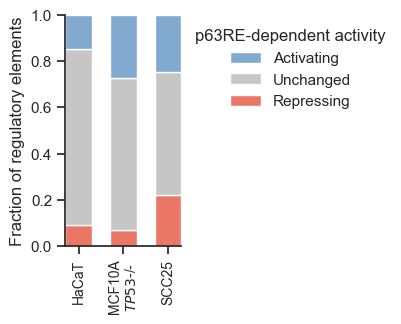

In [3]:
#5B stacked barchart
df_cp = df_fc.copy()
p53_name = 'MCF10A\n$\it{TP53}$-/-'
df_cp.replace({'MCF10A p53KO':p53_name}, inplace=True)
df_cp['cell_line'] = pd.Categorical(df_cp['cell_line'], ['HaCaT',p53_name,'SCC25'])
fig, ax = plt.subplots(figsize=(1.5,3))
sns.histplot(
    data=df_cp,
    x="cell_line", hue="activity", hue_order=['Activating', 'Unchanged','Repressing'],
    multiple="fill", stat="percent", palette= act_palette,
    discrete=True, shrink=.6,ax=ax).set(ylabel = 'Fraction of regulatory elements',xlabel=None)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, size=10)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title = 'p63RE-dependent activity')
fig.savefig(os.path.join(fig_out_path,'5B.pdf'), dpi=300, transparent=True, bbox_inches='tight')

## Figure 5C
 - Reformat data for sankey plot

In [1]:
#sankey graph for all 4 cell types
import pandas as pd
import os
os.chdir('..\data')
#format
tmp = pd.read_excel('Table S3.xlsx', sheet_name='MCF10Ap53KO_HaCaT_SCC25')
tmp = tmp[tmp.enhancer_variant =='WT']
tmp_pivot = tmp.pivot(index='loc', columns='cell_line', values='activity').reset_index()

sankey_tbl = tmp_pivot.value_counts(subset=['HaCaT','MCF10A p53KO','SCC25']).reset_index()
sankey_tbl_ko_hac = tmp_pivot.value_counts(subset=['MCF10A p53KO','HaCaT']).reset_index()
sankey_tbl_ko_scc = tmp_pivot.value_counts(subset=['MCF10A p53KO', 'SCC25']).reset_index()

sankey_tbl.rename(columns={0:'count'}, inplace=True)
sankey_tbl_ko_hac.rename(columns={0:'count'}, inplace=True)
sankey_tbl_ko_scc.rename(columns={0:'count'}, inplace=True)

sankey_tbl['HaCaT'] = 'HaCat, ' + sankey_tbl['HaCaT'].astype(str)
sankey_tbl['MCF10A p53KO'] = 'MCF10A p53KO, ' + sankey_tbl['MCF10A p53KO'].astype(str)
sankey_tbl['SCC25'] = 'SCC25, ' + sankey_tbl['SCC25'].astype(str)

sankey_tbl_ko_hac['MCF10A p53KO'] = 'MCF10A p53KO, ' + sankey_tbl_ko_hac['MCF10A p53KO'].astype(str)
sankey_tbl_ko_hac['HaCaT'] = 'HaCat, ' + sankey_tbl_ko_hac['HaCaT'].astype(str)
sankey_tbl_ko_scc['SCC25'] = 'SCC25, ' + sankey_tbl_ko_scc['SCC25'].astype(str)
sankey_tbl_ko_scc['MCF10A p53KO'] = 'MCF10A p53KO, ' + sankey_tbl_ko_scc['MCF10A p53KO'].astype(str)

source = list(set(sankey_tbl.SCC25.tolist() + sankey_tbl['MCF10A p53KO'].tolist() + sankey_tbl.HaCaT.tolist()))

sankey_tbl_ko_hac[['source', 'target']] = sankey_tbl_ko_hac.apply(lambda row: [source.index(row.HaCaT), source.index(row['MCF10A p53KO'])], axis='columns', result_type='expand')
sankey_tbl_ko_scc[['source', 'target']] = sankey_tbl_ko_scc.apply(lambda row: [source.index(row['MCF10A p53KO']), source.index(row.SCC25)], axis='columns', result_type='expand')

def add_col(col):
	if 'Unchanged' in col: return 'silver'
	elif 'Activating' in col: return 'cornflowerblue'
	elif 'Repressing' in col: return 'salmon'
sankey_tbl_ko_hac['color'] = sankey_tbl_ko_hac['MCF10A p53KO'].apply(lambda x: add_col(x))
sankey_tbl_ko_scc['color'] = sankey_tbl_ko_scc['MCF10A p53KO'].apply(lambda x: add_col(x))
sankey_tbl_ko_scc

,MCF10A p53KO,SCC25,count,source,target,color
0,"MCF10A p53KO, Unchanged","SCC25, Unchanged",3532,8,3,silver
1,"MCF10A p53KO, Unchanged","SCC25, Repressing",1526,8,0,silver
2,"MCF10A p53KO, Unchanged","SCC25, Activating",1311,8,2,silver
3,"MCF10A p53KO, Activating","SCC25, Unchanged",1277,1,3,cornflowerblue
4,"MCF10A p53KO, Activating","SCC25, Activating",1015,1,2,cornflowerblue
5,"MCF10A p53KO, Activating","SCC25, Repressing",351,1,0,cornflowerblue
6,"MCF10A p53KO, Repressing","SCC25, Unchanged",329,4,3,salmon
7,"MCF10A p53KO, Repressing","SCC25, Repressing",275,4,0,salmon
8,"MCF10A p53KO, Repressing","SCC25, Activating",81,4,2,salmon


In [5]:
sankey_tbl_ko_hac

,MCF10A p53KO,HaCaT,count,source,target,color
0,"MCF10A p53KO, Unchanged","HaCat, Unchanged",5073,6,5,silver
1,"MCF10A p53KO, Activating","HaCat, Unchanged",1845,6,4,cornflowerblue
2,"MCF10A p53KO, Unchanged","HaCat, Activating",723,1,5,silver
3,"MCF10A p53KO, Activating","HaCat, Activating",666,1,4,cornflowerblue
4,"MCF10A p53KO, Unchanged","HaCat, Repressing",573,7,5,silver
5,"MCF10A p53KO, Repressing","HaCat, Unchanged",450,6,3,salmon
6,"MCF10A p53KO, Repressing","HaCat, Repressing",194,7,3,salmon
7,"MCF10A p53KO, Activating","HaCat, Repressing",132,7,4,cornflowerblue
8,"MCF10A p53KO, Repressing","HaCat, Activating",41,1,3,salmon


-  Make a sankey plot
- HaCaT <- MCF10A p53KO -> SCC25 order

In [17]:
#this is with all three
#MCF10A p53KO in the center
import plotly.graph_objects as go
import plotly.express as px
import plotly
from plotly.graph_objs import *

fig=go.Figure(data=[go.Sankey(
    node = dict(pad = 15,thickness = 20,line = dict(color = "black", width = 0.5),
    color = ['silver','cornflowerblue','salmon','silver','cornflowerblue','salmon','cornflowerblue','salmon','silver']),
    link = dict(
      source = sankey_tbl_ko_scc.source.tolist() + sankey_tbl_ko_hac.source.tolist(), # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = sankey_tbl_ko_scc.target.tolist() + sankey_tbl_ko_hac.target.tolist(),
      value = sankey_tbl_ko_scc['count'].tolist() + sankey_tbl_ko_hac['count'].tolist(),
	  color = sankey_tbl_ko_scc.color.tolist() + sankey_tbl_ko_hac.color.tolist())
)],
	layout = Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)'))
fig.update_layout(autosize=False,width=400,height=400)
fig.show()
fig.write_image(os.path.join(fig_out_path,"5C.pdf"))

In [12]:
#get numbers to label sankey plot
tmp.value_counts(subset=['cell_line', 'activity'])

cell_line     activity  
HaCaT         Unchanged     7368
MCF10A p53KO  Unchanged     6369
SCC25         Unchanged     5138
MCF10A p53KO  Activating    2643
SCC25         Activating    2407
              Repressing    2152
HaCaT         Activating    1430
              Repressing     899
MCF10A p53KO  Repressing     685
dtype: int64

In [9]:
#shared unchanged
from collections import Counter
locs = tmp[tmp.activity == 'Unchanged']['loc'].tolist()
c= Counter(locs)
n=0
for k,v in c.items():
	if v == 3: n+=1
print(n)

2896


In [7]:
tmp

,loc,enhancer_variant,cell_line,RNA/DNA,activity,obs_score,p63RE_class,strand,p63RE_type,gc,obs_p53
0,chr1_3717092_3717116,WT,MCF10A p53KO,0.590035,Unchanged,20,primary,+,Unique p63RE,48.333333,NaN
1,chr1_5652400_5652424,WT,MCF10A p53KO,1.954091,Unchanged,20,primary,+,Unique p63RE,53.333333,NaN
2,chr1_31575754_31575773,WT,MCF10A p53KO,2.069488,Unchanged,20,secondary,-,Unique p63RE,62.184874,NaN
3,chr1_38027284_38027308,WT,MCF10A p53KO,2.000148,Activating,20,primary,-,Unique p63RE,62.500000,NaN
4,chr1_38117813_38117832,WT,MCF10A p53KO,2.263045,Activating,20,primary,+,p53RE+p63RE,57.983193,11.0
...,...,...,...,...,...,...,...,...,...,...,...
48480,chr9_135951083_135951107,WT,SCC25,0.139301,Repressing,8,primary,+,Unique p63RE,48.333333,NaN
48481,chr9_136484776_136484795,WT,SCC25,0.745343,Repressing,8,secondary,-,Unique p63RE,57.983193,NaN
48482,chr9_136533879_136533893,WT,SCC25,1.310668,Activating,8,senary,-,Unique p63RE,59.166667,NaN
48483,chr9_137062571_137062595,WT,SCC25,1.062340,Repressing,8,primary,-,Unique p63RE,55.833333,NaN


## Figure 5D-E
### TF motif enrichment in activating or repressing enhanser using Homer
- Create 3 lists of p63RE coordinates based on enhancer activity (1.5FC threshold) in SCC25
- Use homer with the foliwing parameters:
	+ *findMotifsGenome.pl*
	+ List of 'Activating' or 'Repressing' p63RE coordinates
	+ *-size* 60 (looks up sequence 60nt in each direction from coordinate center; MPRA enhancer fragments are 119-120nt)
	+ *-bg* list of 'Unchanged' p63RE coordinates
- Use the output knownmotifs.txt table to plot motif enrichment

In [ ]:
#import libraries
import pandas as pd
import os
order = ['Activating', 'Unchanged', 'Repressing']
#import key tables
os.chdir('..\data')
out_path = '..\homer'
df = pd.read_excel('Table S2.xlsx', sheet_name='MCF10Ap53KO_HaCaT_SCC25')
df[['chrom','p63RE_start','p63RE_end']] = df.apply(lambda row: row['loc'].split('_'), result_type='expand', axis='columns')
#only need SCC25s and one variant to remove duplicated locations
filt = df[(df.cell_line == 'SCC25') & (df.enhancer_variant == 'WT')]
df_act = filt[filt.activity == 'Activating']
df_rep = filt[filt.activity == 'Repressing']
df_unch = filt[filt.activity == 'Unchanged']
df_act.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_act_SCC25.txt'), index=False, header=False,sep='\t')
df_rep.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_rep_SCC25.txt'), index=False, header=False,sep='\t')
df_unch.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_unch_SCC25.txt'), index=False, header=False,sep='\t')
filt.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_all_SCC25.txt'), index=False, header=False,sep='\t')
#only need p53KOs and one variant to remove duplicated locations
filt = df[(df.cell_line == 'MCF10A p53KO') & (df.enhancer_variant == 'WT')]
df_act = filt[filt.activity == 'Activating']
df_rep = filt[filt.activity == 'Repressing']
df_unch = filt[filt.activity == 'Unchanged']
df_act.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_act_MCF10Ap53KO_fig5.txt'), index=False, header=False,sep='\t')
df_rep.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_rep_MCF10Ap53KO_fig5.txt'), index=False, header=False,sep='\t')
df_unch.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_unch_MCF10Ap53KO_fig5.txt'), index=False, header=False,sep='\t')
filt.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_all_MCF10Ap53KO_fig5.txt'), index=False, header=False,sep='\t')
#only need HaCaTs and one variant to remove duplicated locations
filt = df[(df.cell_line == 'HaCaT') & (df.enhancer_variant == 'WT')]
df_act = filt[filt.activity == 'Activating']
df_rep = filt[filt.activity == 'Repressing']
df_unch = filt[filt.activity == 'Unchanged']
df_act.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_act_HaCaT.txt'), index=False, header=False,sep='\t')
df_rep.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_rep_HaCaT.txt'), index=False, header=False,sep='\t')
df_unch.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_unch_HaCaT.txt'), index=False, header=False,sep='\t')
filt.loc[:,['loc','chrom','p63RE_start','p63RE_end','strand']].to_csv(os.path.join(out_path,'homer_all_HaCaT.txt'), index=False, header=False,sep='\t')
#run homer motif enrichemnt using these act/rep files and unchanged enhancers as background

 - shared vs unique (MCF10A p53KO and SCC25) p63RE-dependent activiating regulatory elements
 - process HOMER output tables for plotting

In [10]:
import sys
def overlap(r, tbl):
	target = round(r[tbl.columns[5]])
	perc = float(r['% of Target Sequences with Motif'].strip('%'))
	if perc == 0.0:
		return '0'
	total = round((target * 100) / perc)
	ovlp = str(target) + '/' + str(total)
	return ovlp
def size(r):
	target = float(r['% of Target Sequences with Motif'].strip('%'))
	bg = float(r['% of Background Sequences with Motif'].strip('%'))
	if bg == 0.0:
		return '0'
	ovlp = target / bg
	return ovlp
homer_path = '..\homer'
pko = pd.read_csv(os.path.join(homer_path,'homer_act_MCF10Ap53KO_fig5_bg_unch','knownResults.txt'), sep='\t')
scc = pd.read_csv(os.path.join(homer_path,'homer_act_SCC25_bg_unch','knownResults.txt'), sep='\t')
top = 50 #top motifs
pko['cell_line'], scc['cell_line'] = 'MCF10A\n' + '$\it{TP53}$' + '-/-','SCC25' #changes TP53 to italics
#rename variable columns for concatenation
for tbl in [pko, scc]:
	tbl.rename(columns={tbl.columns[5]:'# of Target Sequences with Motif',
	tbl.columns[7]:'# of Background  Sequences with Motif'}, inplace=True)
#merge into one long table
long = pd.concat([pko, scc],axis=0, ignore_index=True)
#simplify motif name by exrtacting short name
long['tf'] = long['Motif Name'].apply(lambda x: x[:x.find('(')])
long['TF'] = long.tf.str.upper()
#calculate % overlap
long['Overlap'] = long.apply(lambda row: overlap(row, long),axis='columns')
long['Enrichment over background'] = long.apply(lambda row: size(row), axis='columns')
long.rename(columns={'q-value (Benjamini)':"Adjusted P-value"},inplace=True)
long = long[(long["Adjusted P-value"] < 0.05) & (long['Motif Name'] != 'p53(p53)/mES-cMyc-ChIP-Seq(GSE11431)/Homer')]
long['log(1/padj)'] = np.log(1 / long['Adjusted P-value'])
#want to inverse padj value and log it, but can't do that with 0, Replace 0 with lowest possible float
long["Adjusted P-value"].replace({0.0:sys.float_info.min}, inplace=True)
long['log(1/padj)'] = np.log(1 / long['Adjusted P-value'])
long['log(1/pval)'] = np.log(1 / long['P-value'])
all_tf = list(set(long.tf.tolist()))
scc_tf = list(set(long[long.cell_line == 'SCC25'].tf.tolist()))
pko_tf = list(set(long[long.cell_line != 'SCC25'].tf.tolist()))
shared_tf = list(set(pko_tf).intersection(scc_tf))
uniq_scc = [tf for tf in scc_tf if tf not in shared_tf]
uniq_pko = [tf for tf in pko_tf if tf not in shared_tf]
long.sample(5)

,Motif Name,Consensus,P-value,Log P-value,Adjusted P-value,# of Target Sequences with Motif,% of Target Sequences with Motif,# of Background Sequences with Motif,% of Background Sequences with Motif,cell_line,tf,TF,Overlap,Enrichment over background,log(1/padj),log(1/pval)
442,Fra2(bZIP)/Striatum-Fra2-ChIP-Seq(GSE43429)/Homer,GGATGACTCATC,1.000000e-07,-16.520,2.225074e-308,140.0,5.82%,187.0,3.64%,SCC25,Fra2,FRA2,140/2405,1.598901,708.396419,16.118096
27,GABPA(ETS)/Jurkat-GABPa-ChIP-Seq(GSE17954)/Homer,RACCGGAAGT,1.000000e-03,-7.868,6.000000e-03,87.0,3.29%,142.3,2.25%,MCF10A\n$\it{TP53}$-/-,GABPA,GABPA,87/2644,1.462222,5.115996,6.907755
39,Elk1(ETS)/Hela-Elk1-ChIP-Seq(GSE31477)/Homer,HACTTCCGGY,1.000000e-02,-5.955,2.890000e-02,40.0,1.51%,60.0,0.95%,MCF10A\n$\it{TP53}$-/-,Elk1,ELK1,40/2649,1.589474,3.543914,4.605170
14,Fra1(bZIP)/BT549-Fra1-ChIP-Seq(GSE46166)/Homer,NNATGASTCATH,1.000000e-05,-12.470,1.000000e-04,152.0,5.75%,249.3,3.94%,MCF10A\n$\it{TP53}$-/-,Fra1,FRA1,152/2643,1.459391,9.210340,11.512925
454,MYNN(Zf)/HEK293-MYNN.eGFP-ChIP-Seq(Encode)/Homer,TTCAAAWTAAAAGTC,1.000000e-03,-7.360,1.900000e-02,7.0,0.29%,4.0,0.08%,SCC25,MYNN,MYNN,7/2414,3.625,3.963316,6.907755


### Figure 5D

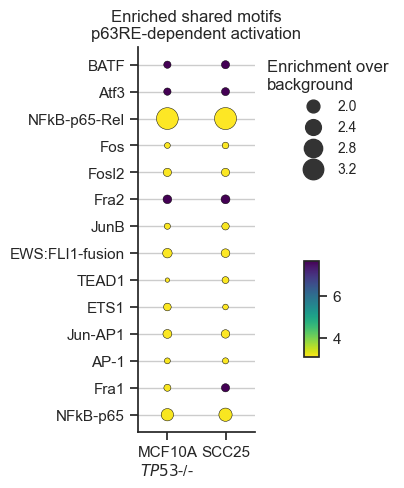

In [6]:
sns.set_style({'axes.grid.axis' : 'y','axes.grid' : True})
df_shared = long[long.tf.isin(shared_tf)]
df_shared['tf'] = pd.Categorical(df_shared['tf'], ['BATF','Atf3', 'NFkB-p65-Rel','Fos', 'Fosl2', 'Fra2','JunB', 'EWS:FLI1-fusion','TEAD1','ETS1','Jun-AP1', 'AP-1', 'Fra1', 'NFkB-p65'])
df_shared.sort_values(by='tf', inplace=True)
fig, ax = plt.subplots(figsize=(1.5,5))
sns.scatterplot(data=df_shared, x='cell_line', y='tf', hue='log(1/padj)', size= 'Enrichment over background',
				sizes=(10,250),palette='viridis_r',edgecolor='black',ax=ax).set(ylabel = None,xlim=(-0.5, 1.5), title='Enriched shared motifs\np63RE-dependent activation', xlabel=None)
ax.axes.xaxis.grid(False)
norm = plt.Normalize(df_shared['log(1/padj)'].min(), df_shared['log(1/padj)'].median())
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
sm.set_array([])
cax = fig.add_axes([ax.get_position().x1+0.33, ax.get_position().y0+0.15, 0.1, ax.get_position().height / 4])
ax.figure.colorbar(sm, cax=cax)
h, l = ax.get_legend_handles_labels()
# slice the appropriate section of l and h to include in the legend
ax.legend(h[7:], l[7:], bbox_to_anchor=(1, 1), fontsize=10,frameon = False, title='Enrichment over\nbackground')
fig.savefig(os.path.join(fig_out_path,'5D.eps'), dpi=300, transparent=True, bbox_inches='tight')

### Figure 5E

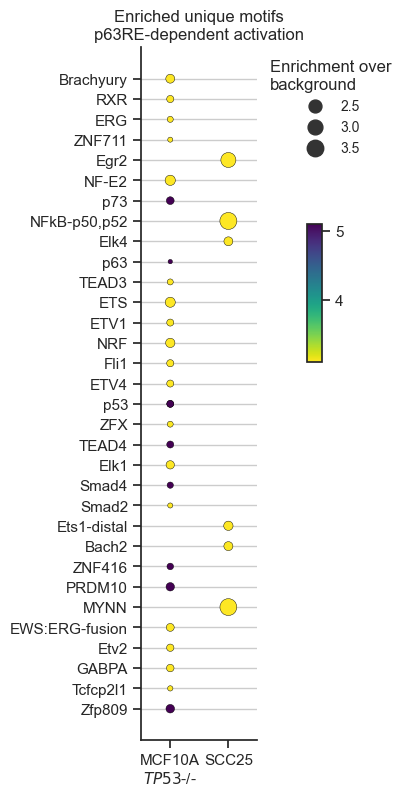

In [20]:
#unique motifs enriched btw cell types
sns.set_style({'axes.grid.axis' : 'y','axes.grid' : True})
df_uniq = long[long.tf.isin(uniq_pko + uniq_scc)]
#this TF order is made to match order in a heatmap in 5F below
df_uniq['tf'] = pd.Categorical(df_uniq['tf'], ['Brachyury', 'RXR', 'ERG','ZNF711', 'Egr2', 'NF-E2','p73','NFkB-p50,p52','Elk4', 'p63', 'TEAD3','ETS', 'ETV1','NRF', 'Fli1','ETV4','p53','ZFX','TEAD4',
											    'Elk1', 'Smad4','Smad2', 'Ets1-distal','Bach2', 'ZNF416','PRDM10','MYNN','EWS:ERG-fusion','Etv2','GABPA',
											        'Tcfcp2l1', 'Zfp809'])
df_uniq.sort_values(by='tf', inplace=True)
fig, ax = plt.subplots(figsize=(1.5,9))
sns.scatterplot(data=df_uniq, x='cell_line', y='tf', hue='log(1/padj)', size= 'Enrichment over background',
				sizes=(10,150),palette='viridis_r',edgecolor='black',ax=ax).set(ylabel = None,xlim=(-0.5, 1.5), title='Enriched unique motifs\np63RE-dependent activation', xlabel=None)
ax.axes.xaxis.grid(False)
norm = plt.Normalize(df_uniq['log(1/padj)'].min(), df_uniq['log(1/padj)'].median())
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=norm)
sm.set_array([])
cax = fig.add_axes([ax.get_position().x1+0.33, ax.get_position().y0+0.42, 0.1, ax.get_position().height / 5])
ax.figure.colorbar(sm, cax=cax)
h, l = ax.get_legend_handles_labels()
# slice the appropriate section of l and h to include in the legend
ax.legend(h[8:], l[8:], bbox_to_anchor=(1, 1), fontsize=10,frameon = False, title='Enrichment over\nbackground')
fig.savefig(os.path.join(fig_out_path,'5E.eps'), dpi=300, transparent=True, bbox_inches='tight')

## Figure 5F
 - First, run DESEQ2 analysis comparing MCF10A p53KO + DMSO and SCC25 + shRNA_ctrl
 - Use Lambert et al, 2018 table indentifying gene names that are TFs
 - Extract just the TF of interest expression data (vst) for plotting
 - Group by TFs upregulated in SCC25 or MCF10A p53KO relative to each other

In [2]:
# os.chdir(r'..\fastq_rnaseq')
os.chdir(r'..\data')
#import TFs names
all_tf = pd.read_csv('all_TFs_lambert2018.csv', usecols=['ID','Name'])
all_tf.rename(columns={'ID':'ensembl_gene_id'}, inplace=True)
#import rnaseq vst values
vst = pd.read_csv('deseq2_vst_MCF10Ap53KO_vs_SCC25.csv')
vst.rename(columns={'ID':'ensembl_gene_id'}, inplace=True)
#import deseq results of MCF10A vs SCC
pkovsscc = pd.read_csv('deseq2_MCF10Ap53KO_DMSO_vs_SCC25_ctrl_shRNA.csv', index_col=0)
pkovsscc.drop(columns=['lfcSE','stat','pvalue', 'transcript_is_canonical'], inplace=True)
#merge TF names and keep only TFs
pkovsscc = pkovsscc.merge(all_tf, how='left', on='ensembl_gene_id')
pkovsscc.dropna(subset=['Name'], how='any', inplace=True)
#merge vst values
pkovsscc = pkovsscc.merge(vst[['MCF10Ap53KO_DMSO_1', 'MCF10Ap53KO_DMSO_2', 'MCF10Ap53KO_DMSO_3',
							   'SCC25_ctr_shRNA_1', 'SCC25_ctr_shRNA_2','ensembl_gene_id']], how='left', on='ensembl_gene_id')
tf_shared = ['ATF3','BATF','ETS1','TEAD1', 'JUNB', 'REL',
		  'EWSR1','FLI1', 'FOS','FOSL1','FOSL2','JUN']
tf_mcf = [ 'T','ERG','ETS1','ETS2','ETV1','ETV2','ETV4','ELK1', 'EWSR1', 'ZFX','ZNF416', 'ZNF711', 'SMAD2','SMAD4',
		 'TEAD3', 'TEAD4','PRDM10','RXRG','RXRA','RXRB','NFE2','FLI1', 'GABPA',
		 'NRF1', 'EWSR1', 'TP53','TP63','TP73']
tf_scc = ['ETS1','MYNN','NFKB1','NFKB2','BACH2','ELK4','EGR2']
#only keep our TFs from fig 5DE
tf_ensbl_uniq = all_tf[all_tf.Name.isin(tf_mcf + tf_scc)].ensembl_gene_id.tolist()
tf_ensbl_shared = all_tf[all_tf.Name.isin(tf_shared)].ensembl_gene_id.tolist()
unique = pkovsscc[pkovsscc.ensembl_gene_id.isin(tf_ensbl_uniq)].copy()
shared = pkovsscc[pkovsscc.ensembl_gene_id.isin(tf_ensbl_shared)].copy()
# pkovsscc = pkovsscc[pkovsscc.ensembl_gene_id != ]
#add col labels
def rnaseq(fc, p):
	if np.isnan(fc) == True: return ['NA', 'NA']
	if p < 0.05:
		if fc > 0: return ['p-value < 0.05','Upregulated in SCC25']
		elif fc < 0: return ['p-value < 0.05','Upregulated in MCF10A TP53-/-']
	elif p >= 0.05:
		if fc > 0: return ['p-value > 0.05','Upregulated in SCC25']
		elif fc < 0: return ['p-value > 0.05','Upregulated in MCF10A TP53-/-']
def tf_ori(tf):
	if tf in tf_mcf: return 'MCF10A p53KO'
	elif tf in tf_scc: return 'SCC25'
unique[['Adjusted p-value','Fold Change']] = unique.apply(lambda row: rnaseq(row.log2FoldChange, row.padj), axis='columns', result_type='expand')
unique['tf_ori'] = unique.Name.apply(lambda x: tf_ori(x))
shared[['Adjusted p-value','Fold Change']] = shared.apply(lambda row: rnaseq(row.log2FoldChange, row.padj), axis='columns', result_type='expand')
#sort in a specific order
unique['Adjusted p-value'] = pd.Categorical(unique['Adjusted p-value'], ["NA", "p-value < 0.05", "p-value > 0.05"])
unique['Fold Change'] = pd.Categorical(unique['Fold Change'], ["NA","Upregulated in SCC25", "Upregulated in MCF10A TP53-/-"])
unique.sort_values(by=['Adjusted p-value','Fold Change','MCF10Ap53KO_DMSO_1'], inplace=True)
shared['Adjusted p-value'] = pd.Categorical(shared['Adjusted p-value'], ["NA", "p-value < 0.05", "p-value > 0.05"])
shared['Fold Change'] = pd.Categorical(shared['Fold Change'], ["NA","Upregulated in SCC25", "Upregulated in MCF10A TP53-/-"])
shared.sort_values(by=['Adjusted p-value','Fold Change','MCF10Ap53KO_DMSO_1'], inplace=True)
#note: brachyuri/T/TBXT has nan values in rnaseq
del(vst, all_tf)
shared.sample(5)

,ensembl_gene_id,baseMean,log2FoldChange,padj,hgnc_symbol,chromosome_name,start_position,end_position,strand,Name,MCF10Ap53KO_DMSO_1,MCF10Ap53KO_DMSO_2,MCF10Ap53KO_DMSO_3,SCC25_ctr_shRNA_1,SCC25_ctr_shRNA_2,Adjusted p-value,Fold Change
1348,ENSG00000151702,832.636609,-1.056199,5.035624e-05,FLI1,11,128686535,128813267,1,FLI1,10.637086,10.766306,10.926722,10.016320,10.346813,p-value < 0.05,Upregulated in MCF10A TP53-/-
1805,ENSG00000171223,19509.000922,3.333628,4.319854e-111,JUNB,19,12791486,12793315,1,JUNB,12.491673,12.111596,12.216132,15.332654,15.465357,p-value < 0.05,Upregulated in SCC25
1404,ENSG00000156127,6.939603,3.038052,7.653554e-02,BATF,14,75522455,75546993,1,BATF,8.647557,8.723795,8.792486,8.879366,8.962208,p-value > 0.05,Upregulated in SCC25
1514,ENSG00000162772,495.138753,3.747811,1.674769e-05,ATF3,1,212565334,212620777,1,ATF3,9.521196,9.157579,9.138560,10.376130,11.174332,p-value < 0.05,Upregulated in SCC25
209,ENSG00000075426,5801.852695,1.703879,1.565483e-05,FOSL2,2,28392448,28417317,1,FOSL2,12.276658,11.509312,11.790580,13.484962,13.283643,p-value < 0.05,Upregulated in SCC25


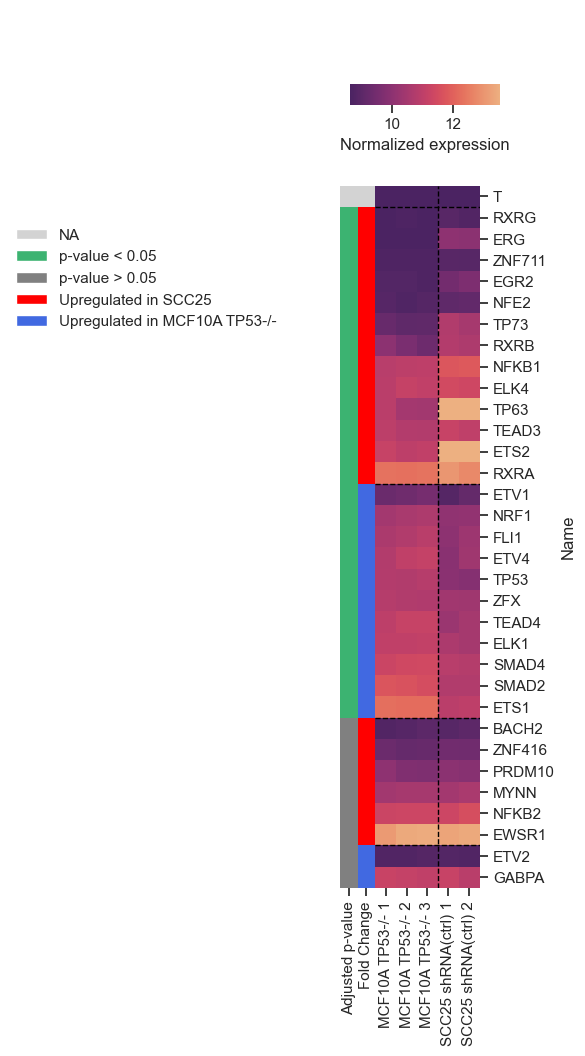

In [19]:
hm = unique[['Name','MCF10Ap53KO_DMSO_1', 'MCF10Ap53KO_DMSO_2', 'MCF10Ap53KO_DMSO_3',
       'SCC25_ctr_shRNA_1', 'SCC25_ctr_shRNA_2', 'Fold Change','Adjusted p-value']].copy()
hm = hm.set_index('Name')
fc = hm.pop('Fold Change')
sign = hm.pop('Adjusted p-value')
lut = {'NA':'lightgrey', 'p-value < 0.05':'mediumseagreen', 'p-value > 0.05':'grey', 'Upregulated in SCC25':'red', 'Upregulated in MCF10A TP53-/-':'royalblue'}
row_colors1 = fc.map(lut)
row_colors2 = sign.map(lut)
row_colors = pd.concat([row_colors2,row_colors1], axis=1)
fig = sns.clustermap(hm, row_colors=row_colors, cmap="flare_r", figsize=(3, 11), row_cluster=False, col_cluster=False, colors_ratio=0.1,robust=True, cbar_pos=(.2, .9, .5, .019),
                   cbar_kws={"orientation": "horizontal", 'label': 'Normalized expression'})
fig.ax_heatmap.axvline(x=3, linewidth=1, color="black", linestyle='dashed')
#fig.ax_heatmap.hlines(y=[1,11,22,25,27,30],xmin=0,xmax=5, linewidth=1, color="black", linestyles='dashed')
fig.ax_heatmap.hlines(y=[1,14,25,31],xmin=0,xmax=5, linewidth=1, color="black", linestyles='dashed')
fig.ax_heatmap.set_facecolor('lightgrey')
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, frameon=False,
           bbox_to_anchor=(0, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')
fig.ax_heatmap.set_xticklabels(['MCF10A TP53-/- 1', 'MCF10A TP53-/- 2','MCF10A TP53-/- 3', 'SCC25 shRNA(ctrl) 1', 'SCC25 shRNA(ctrl) 2'])
fig.savefig(os.path.join(fig_out_path, '5F.eps'), dpi=300, transparent=True, bbox_inches='tight')